# CAMEX integrates testis scRNA-seq dataset across 11 species


This tutorial demonstrates that CAMEX uncovers the conserved differentiation process in the testis across 11 species. 

Here, we use a testis scRNA-seq dataset across 11 species. Processed h5ad files can be downloaded from https://drive.google.com/drive/folders/1rwdjEvWFEFw82a0x2JzMi2jXICbUc5eb?usp=sharing

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import torch
import shutil
import warnings
import argparse
import importlib
import scanpy as sc

import pandas as pd
import numpy as mp

from CAMEX.base import Dataset
from CAMEX.trainer import Trainer

In [2]:
from params import PARAMS

In [3]:
t1 = time.time()

## make log dir

In [4]:
time_start = time.strftime("%Y-%m-%d-%H-%M-%S")
log_path = f'./log/{time_start}/'
for k, v in PARAMS.items():
    v['time_start'] = time_start
    v['log_path'] = log_path
print(log_path)

./log/2024-04-12-17-02-43/


In [5]:
os.makedirs(log_path, exist_ok=True)
shutil.copy('params.py', log_path + 'params_current.py')
print(f'time: {time_start}')

time: 2024-04-12-17-02-43


## preprocess scRNA_seq data to construct a heterogeneous graph of cells and genes

In [6]:
#  —————————————————————————————————— 1 preprocess
print('start preprocess')
dataset = Dataset(**PARAMS['preprocess'])
adata_CAMEX = dataset.adata_whole
dgl_data = dataset.dgl_data

start preprocess
               raw-testis-human-Murat: reference  raw-testis-chimpanzee-Murat: query  raw-testis-bonobo-Murat: query  raw-testis-gorilla-Murat: query  raw-testis-gibbon-Murat: query  raw-testis-macaque-Murat: query  raw-testis-marmoset-Murat: query  raw-testis-mouse-Murat: query  raw-testis-opossum-Murat: query  raw-testis-platypus-Murat: query  raw-testis-chicken-Murat: query
spermatids                                  6359                                6044                            5452                             3144                            2050                             2794                              3266                           2629                             3475                            4500.0                             3501
Spermatocytes                               3878                                3210                            2802                             1640                            1932                             1781         

In [7]:
print('start train')
trainer = Trainer(adata_CAMEX, dgl_data, **PARAMS['train'])

start train


## integration

In [8]:
trainer.integration()

--------------------------------------------- integration ---------------------------------------------
epoch: 0, loss: 165.27696962284864
epoch: 1, loss: 76.95408240296787
epoch: 2, loss: 76.09822329184166
epoch: 3, loss: 75.63389971740264
epoch: 4, loss: 75.28416913254817
epoch: 5, loss: 75.07050793870052
epoch: 6, loss: 74.85558778002746
epoch: 7, loss: 74.74335967329212
epoch: 8, loss: 74.53497951192067
epoch: 9, loss: 74.40225363136234


In [9]:
adata_CAMEX.write_h5ad(log_path + 'adata_CAMEX.h5ad', compression='gzip')

In [10]:
t2 = time.time()

In [11]:
print(f'time usage: {round(t2-t1)} seconds')

time usage: 1819 seconds


## analysis

In [12]:
log_path

'./log/2024-04-12-17-02-43/'

In [13]:
adata_CAMEX = sc.read_h5ad(log_path + 'adata_CAMEX.h5ad')
adata_CAMEX

AnnData object with n_obs × n_vars = 96464 × 2000
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class', 'batch', 'n_genes_by_counts', 'total_counts', 'cell_ontology_class_num', 'cell_class', 'cell_class_num'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type', 'data_order', 'dataset_description', 'dataset_type', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_CAMEX_Integration', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [14]:
adata_CAMEX.obsm['X_CAMEX_Integration'].shape

(96464, 128)

In [15]:
sc.pp.neighbors(adata_CAMEX, use_rep='X_CAMEX_Integration')

In [16]:
sc.tl.umap(adata_CAMEX)

In [17]:
sc.tl.leiden(adata_CAMEX, resolution=0.2)

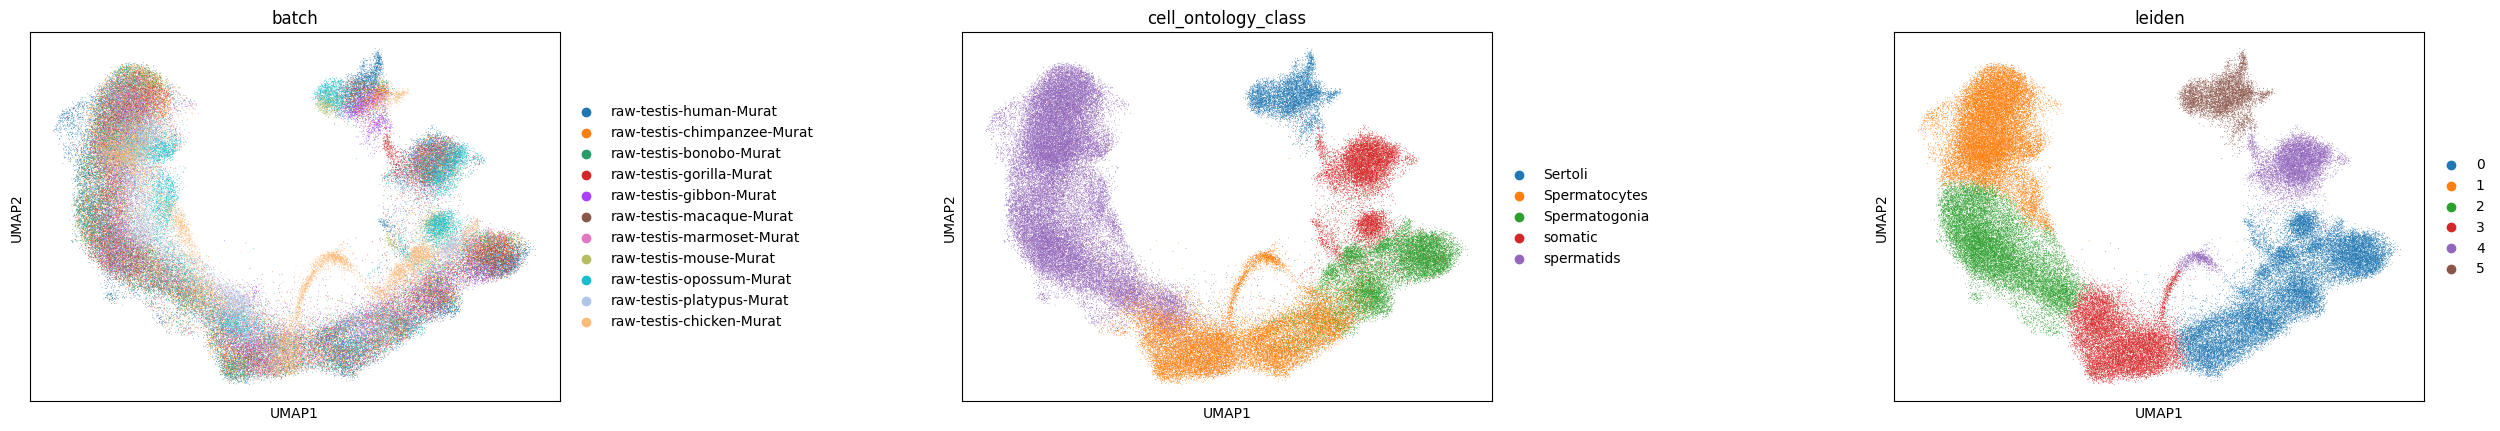

In [18]:
sc.pl.umap(adata_CAMEX, color=['batch', 'cell_ontology_class', 'leiden'], wspace=0.6)

## Manually concatenate the 11 species scRNA-seq datasets and utilize Harmony for integration.

### human

In [2]:
adata_human = sc.read_h5ad('./dataset/raw-testis-human-Murat.h5ad')
adata_human

AnnData object with n_obs × n_vars = 16011 × 26186
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [3]:
adata_human.var_names_make_unique()
adata_human.obs_names_make_unique()

In [4]:
adata_human.X.max()

1409.0

### chimpanzee

In [5]:
adata_chimpanzee = sc.read_h5ad('./dataset/raw-testis-chimpanzee-Murat.h5ad')
adata_chimpanzee

AnnData object with n_obs × n_vars = 12329 × 14705
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [6]:
gene_array = pd.read_csv('./dataset/gene_matches_human2chimpanzee.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_chimpanzee.var.index) & set(gene_dict.keys()))

In [7]:
adata_chimpanzee = adata_chimpanzee[:, gene_sub].copy()
adata_chimpanzee

AnnData object with n_obs × n_vars = 12329 × 14455
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [8]:
adata_chimpanzee.var.index = adata_chimpanzee.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_chimpanzee

AnnData object with n_obs × n_vars = 12329 × 14455
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [9]:
adata_chimpanzee.var_names_make_unique()
adata_chimpanzee.obs_names_make_unique()

### bonobo

In [10]:
adata_bonobo = sc.read_h5ad('./dataset/raw-testis-bonobo-Murat.h5ad')
adata_bonobo

AnnData object with n_obs × n_vars = 9873 × 14743
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [11]:
gene_array = pd.read_csv('./dataset/gene_matches_human2bonobo.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_bonobo.var.index) & set(gene_dict.keys()))

In [12]:
adata_bonobo = adata_bonobo[:, gene_sub].copy()
adata_bonobo

AnnData object with n_obs × n_vars = 9873 × 12843
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [13]:
adata_bonobo.var.index = adata_bonobo.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_bonobo

AnnData object with n_obs × n_vars = 9873 × 12843
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [14]:
adata_bonobo.var_names_make_unique()
adata_bonobo.obs_names_make_unique()

### gorilla

In [15]:
adata_gorilla = sc.read_h5ad('./dataset/raw-testis-gorilla-Murat.h5ad')
adata_gorilla

AnnData object with n_obs × n_vars = 7323 × 14717
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [16]:
gene_array = pd.read_csv('./dataset/gene_matches_human2gorilla.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_gorilla.var.index) & set(gene_dict.keys()))

In [17]:
adata_gorilla = adata_gorilla[:, gene_sub].copy()
adata_gorilla

AnnData object with n_obs × n_vars = 7323 × 14680
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [18]:
adata_gorilla.var.index = adata_gorilla.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_gorilla

AnnData object with n_obs × n_vars = 7323 × 14680
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [19]:
adata_gorilla.var_names_make_unique()
adata_gorilla.obs_names_make_unique()

### gibbon

In [20]:
adata_gibbon = sc.read_h5ad('./dataset/raw-testis-gibbon-Murat.h5ad')
adata_gibbon

AnnData object with n_obs × n_vars = 6572 × 13419
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [21]:
gene_array = pd.read_csv('./dataset/gene_matches_human2gibbon.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_gibbon.var.index) & set(gene_dict.keys()))

In [22]:
adata_gibbon = adata_gibbon[:, gene_sub].copy()
adata_gibbon

AnnData object with n_obs × n_vars = 6572 × 13416
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [23]:
adata_gibbon.var.index = adata_gibbon.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_gibbon

AnnData object with n_obs × n_vars = 6572 × 13416
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [24]:
adata_gibbon.var_names_make_unique()
adata_gibbon.obs_names_make_unique()

### macaque

In [25]:
adata_macaque = sc.read_h5ad('./dataset/raw-testis-macaque-Murat.h5ad')
adata_macaque

AnnData object with n_obs × n_vars = 7618 × 13333
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [26]:
gene_array = pd.read_csv('./dataset/gene_matches_human2macaque.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_macaque.var.index) & set(gene_dict.keys()))

In [27]:
adata_macaque = adata_macaque[:, gene_sub].copy()
adata_macaque

AnnData object with n_obs × n_vars = 7618 × 12842
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [28]:
adata_macaque.var.index = adata_macaque.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_macaque

AnnData object with n_obs × n_vars = 7618 × 12842
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [29]:
adata_macaque.var_names_make_unique()
adata_macaque.obs_names_make_unique()

### marmoset

In [30]:
adata_marmoset = sc.read_h5ad('./dataset/raw-testis-marmoset-Murat.h5ad')
adata_marmoset

AnnData object with n_obs × n_vars = 6384 × 11078
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [31]:
gene_array = pd.read_csv('./dataset/gene_matches_human2marmoset.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_marmoset.var.index) & set(gene_dict.keys()))

In [32]:
adata_marmoset = adata_marmoset[:, gene_sub].copy()
adata_marmoset

AnnData object with n_obs × n_vars = 6384 × 11041
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [33]:
adata_marmoset.var.index = adata_marmoset.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_marmoset

AnnData object with n_obs × n_vars = 6384 × 11041
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [34]:
adata_marmoset.var_names_make_unique()
adata_marmoset.obs_names_make_unique()

### mouse

In [35]:
adata_mouse = sc.read_h5ad('./dataset/raw-testis-mouse-Murat.h5ad')
adata_mouse

AnnData object with n_obs × n_vars = 5264 × 24208
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [36]:
gene_array = pd.read_csv('./dataset/gene_matches_human2mouse.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_mouse.var.index) & set(gene_dict.keys()))

In [37]:
adata_mouse = adata_mouse[:, gene_sub].copy()
adata_mouse

AnnData object with n_obs × n_vars = 5264 × 15618
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [38]:
adata_mouse.var.index = adata_mouse.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_mouse

AnnData object with n_obs × n_vars = 5264 × 15618
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [39]:
adata_mouse.var_names_make_unique()
adata_mouse.obs_names_make_unique()

### opossum

In [40]:
adata_opossum = sc.read_h5ad('./dataset/raw-testis-opossum-Murat.h5ad')
adata_opossum

AnnData object with n_obs × n_vars = 9926 × 9697
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [41]:
gene_array = pd.read_csv('./dataset/gene_matches_human2opossum.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_opossum.var.index) & set(gene_dict.keys()))

In [42]:
adata_opossum = adata_opossum[:, gene_sub].copy()
adata_opossum

AnnData object with n_obs × n_vars = 9926 × 9670
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [43]:
adata_opossum.var.index = adata_opossum.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_opossum

AnnData object with n_obs × n_vars = 9926 × 9670
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [44]:
adata_opossum.var_names_make_unique()
adata_opossum.obs_names_make_unique()

### platypus

In [45]:
adata_platypus = sc.read_h5ad('./dataset/raw-testis-platypus-Murat.h5ad')
adata_platypus

AnnData object with n_obs × n_vars = 6751 × 11790
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [46]:
gene_array = pd.read_csv('./dataset/gene_matches_human2platypus.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_platypus.var.index) & set(gene_dict.keys()))

In [47]:
adata_platypus = adata_platypus[:, gene_sub].copy()
adata_platypus

AnnData object with n_obs × n_vars = 6751 × 11434
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [48]:
adata_platypus.var.index = adata_platypus.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_platypus

AnnData object with n_obs × n_vars = 6751 × 11434
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [49]:
adata_platypus.var_names_make_unique()
adata_platypus.obs_names_make_unique()

### chicken

In [50]:
adata_chicken = sc.read_h5ad('./dataset/raw-testis-chicken-Murat.h5ad')
adata_chicken

AnnData object with n_obs × n_vars = 8413 × 10725
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [51]:
gene_array = pd.read_csv('./dataset/gene_matches_human2chicken.csv').to_numpy()
gene_dict = {item[1]: item[0] for item in gene_array}
gene_sub = list(set(adata_chicken.var.index) & set(gene_dict.keys()))

In [52]:
adata_chicken = adata_chicken[:, gene_sub].copy()
adata_chicken

AnnData object with n_obs × n_vars = 8413 × 9333
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [53]:
adata_chicken.var.index = adata_chicken.var.loc[:, 'gene_symbol'].apply(lambda x: gene_dict[x])
adata_chicken

AnnData object with n_obs × n_vars = 8413 × 9333
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class'
    var: 'gene', 'gene_symbol'

In [54]:
adata_chicken.var_names_make_unique()
adata_chicken.obs_names_make_unique()

## concat

In [58]:
adata_11species = sc.concat([adata_human, adata_chimpanzee, adata_bonobo, adata_gorilla, adata_gibbon, adata_macaque, adata_marmoset,
                            adata_mouse, adata_opossum, adata_platypus, adata_chicken], label='batch', 
                            keys=['human', 'chimpanzee', 'bonobo', 'gorilla', 'gibbon', 'macaque', 'marmoset', 'mouse','opossum', 'platypus', 'chicken'])

In [60]:
adata_11species

AnnData object with n_obs × n_vars = 96464 × 3048
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class', 'batch'

In [62]:
adata_11species.var.loc[:, 'symbol'] = adata_11species.var.index

In [63]:
adata_11species.layers['counts'] = adata_11species.X.toarray()
adata_11species.raw = adata_11species
adata_11species.X.max(), adata_11species.layers['counts'].max()

(351.0, 351.0)

In [64]:
sc.pp.normalize_total(adata_11species)
sc.pp.log1p(adata_11species)

In [66]:
sc.pp.highly_variable_genes(adata_11species, batch_key='batch', subset=True, n_top_genes=2000)
adata_11species

AnnData object with n_obs × n_vars = 96464 × 2000
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class', 'batch'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [67]:
sc.pp.pca(adata_11species)

In [68]:
sc.pp.neighbors(adata_11species)

In [69]:
sc.tl.umap(adata_11species)

C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


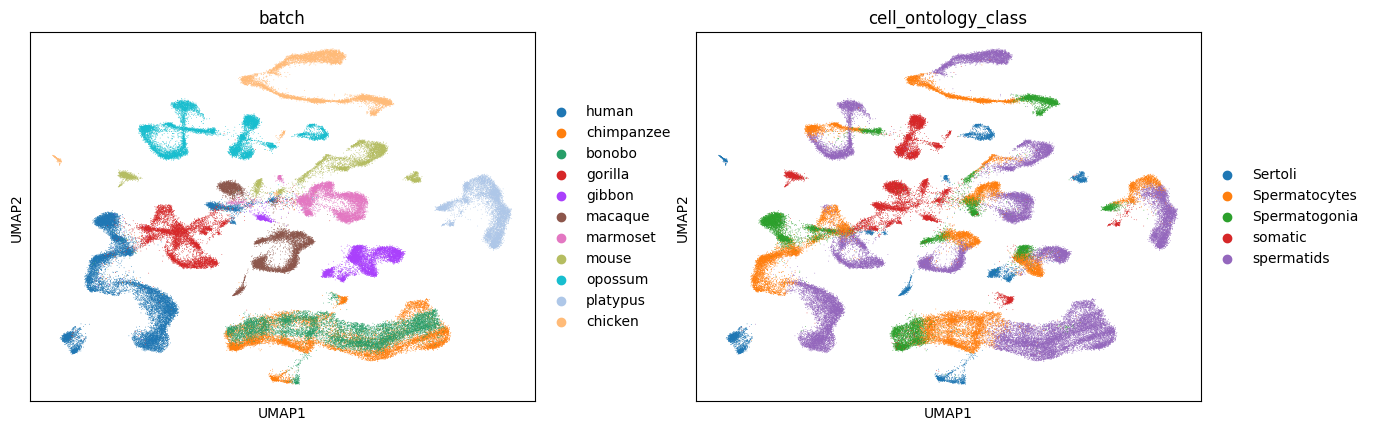

In [70]:
sc.pl.umap(adata_11species, color=['batch', 'cell_ontology_class'], wspace=0.2)

## harmnoy integrate

In [71]:
import scanpy.external as sce

In [72]:
adata_harmony = adata_11species.copy()
adata_harmony

AnnData object with n_obs × n_vars = 96464 × 2000
    obs: 'sample_batch', 'cell_type', 'cell_ontology_class', 'batch'
    var: 'symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [73]:
sce.pp.harmony_integrate(adata_harmony, 'batch')

2024-03-21 08:54:49,716 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-21 08:55:18,106 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-21 08:55:18,904 - harmonypy - INFO - Iteration 1 of 10
2024-03-21 08:56:49,743 - harmonypy - INFO - Iteration 2 of 10
2024-03-21 08:58:06,853 - harmonypy - INFO - Converged after 2 iterations


C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


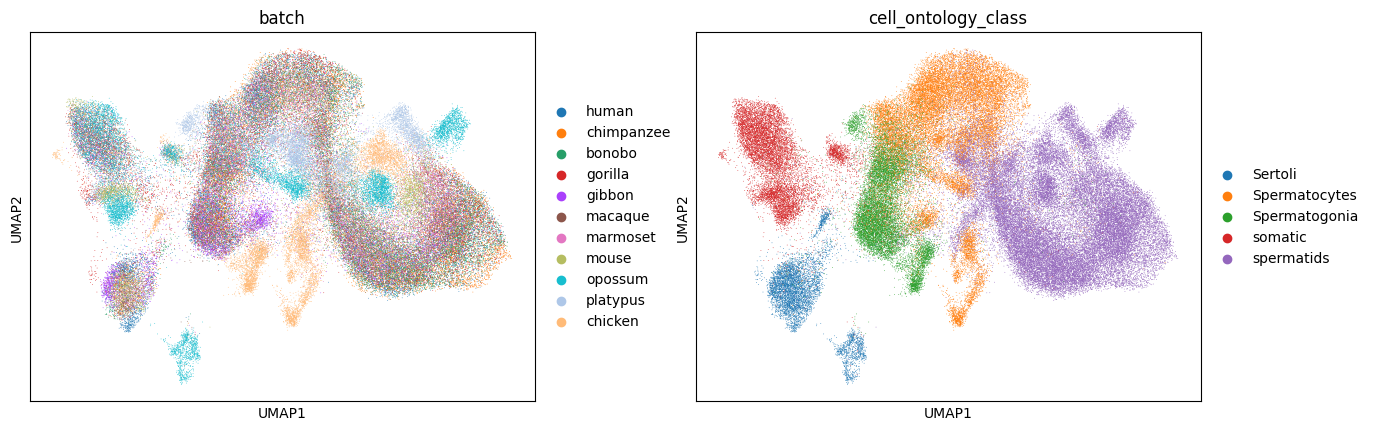

In [74]:
sc.pp.neighbors(adata_harmony, use_rep='X_pca_harmony')
sc.tl.umap(adata_harmony)
sc.pl.umap(adata_harmony, color=['batch', 'cell_ontology_class'], wspace=0.2)